In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import scipy.stats as sps
import mplcyberpunk
import scipy.stats as sps

In [22]:
df = pd.read_csv('isomiR_CPM.tsv', sep = '\t')
cond_cancer = df.columns.str.contains('-01[A-Z]', regex = True)
df_cancer = df[df.columns[cond_cancer]]
df_normal = df[df.columns[~cond_cancer]]

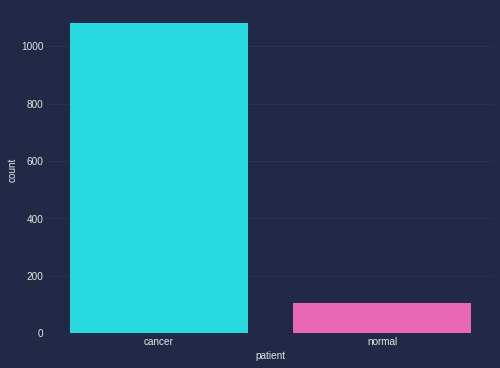

In [53]:
# распределение классов (больные и здоровые)
classes = pd.DataFrame(
    ["cancer"]*df_cancer.shape[1] + ["normal"]*df_normal.shape[1],
    index = list(df_cancer.columns) + list(df_normal.columns), columns = ['patient'])

plt.figure(figsize = (8, 6))
sns.countplot(data = classes, x = 'patient')
plt.show()

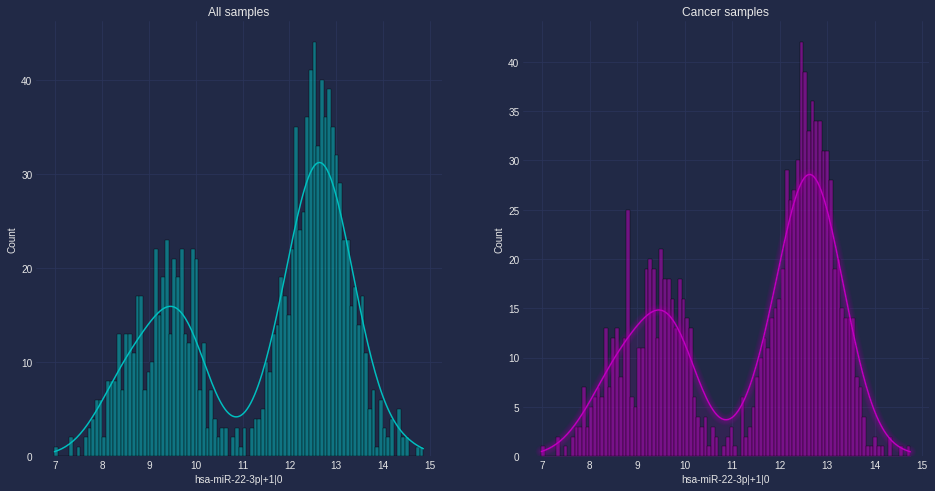

In [23]:
# достаем изоформу
mir22 = df.loc["hsa-miR-22-3p|+1|0"]
mir22_cancer = df_cancer.loc["hsa-miR-22-3p|+1|0"]

# гистограммы для всех и только для больных
fig, axs = plt.subplots(1, 2,  figsize = (16, 8))
sns.histplot(mir22, kde = True, color = 'c', bins = 100, ax = axs[0])
sns.histplot(mir22_cancer, kde = True, color = 'm', bins = 100, ax = axs[1])
mplcyberpunk.add_glow_effects()
axs[0].title.set_text('All samples')
axs[1].title.set_text('Cancer samples')
plt.show()

#### Создаю аннотацию, делая порог на разделение групп по 11

In [74]:
def annotation(table, miRNA):
    cond = miRNA < 11
    left, right = miRNA[cond], miRNA[~cond]
    left_sample, right_sample = table[left.index], table[right.index]
    row = list(['left' if i in left else 'right' for i in table.columns])
    ann = pd.DataFrame(row, index = table.columns, columns = ['Tissue'])
    ann.to_csv('annotation.tsv', sep = '\t')
    return ann, left, right

In [75]:
ann_all, left, right = annotation(df, mir22)
ann_cancer, left, right = annotation(df_cancer, mir22_cancer)

#### Из всех каунтов нужно сохранить только соотв-щие раковым образцам

In [76]:
# gene_counts = pd.read_csv('gene_counts.tsv', sep = '\t', index_col = 0)
# cancer_counts = gene_counts[gene_counts.columns[cond_cancer]]
# cancer_counts.to_csv('gene_cancer_counts.tsv', sep = '\t')

#### Смотрим результаты Deseq2

In [77]:
data_all  = pd.read_csv('gene_deseq2_R.tsv', sep = '\t').dropna()
data_cancer = pd.read_csv('cancer_gene_deseq2_R.tsv', sep = '\t').dropna()

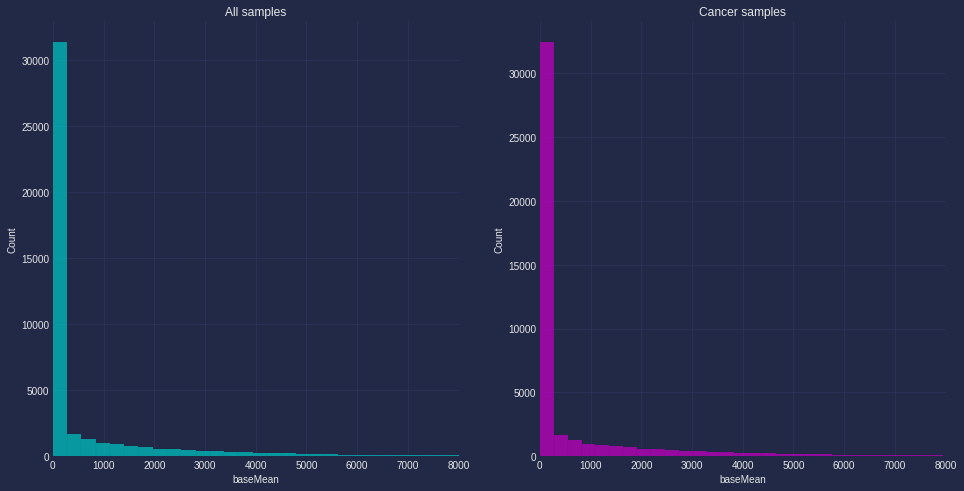

In [78]:
# гистограммы для всех и только для больных
fig, axs = plt.subplots(1, 2,  figsize = (16, 8))
sns.histplot(data = data_all, x = 'baseMean', color = 'c', bins = 2000, ax = axs[0])
sns.histplot(data = data_cancer, x = 'baseMean', color = 'm', bins = 2000, ax = axs[1])
axs[0].set_xlim([0, 8000])
axs[1].set_xlim([0, 8000])

axs[0].title.set_text('All samples')
axs[1].title.set_text('Cancer samples')
plt.show()

#### Выбираем порог для поиска диф.экспр. генов

In [102]:
cond = lambda i: (i['baseMean'] > 1000) & (i['padj'] < 0.05) & (abs(i['log2FoldChange']) > 1)
target_all = data_all.loc[cond]
target_cancer = data_cancer.loc[cond]

In [103]:
list_differ = list(set(target_cancer.index) - set(target_all.index))
target_cancer.loc[list_differ]

,baseMean,log2FoldChange,lfcSE,pvalue,padj
JOSD2,1041.076817,1.006452,0.056906,9.094907e-71,6.086900e-68
FGFR2,2973.868031,-1.028426,0.088182,1.122989e-07,3.665176e-07
ACKR1,1421.301958,1.054759,0.123013,1.442572e-18,1.285015e-17
CFD,1938.158027,1.189528,0.108989,1.482757e-28,3.334005e-27
MYO15B,1846.419978,1.092187,0.062778,1.099207e-68,5.955349e-66
MIB2,1235.439222,1.032940,0.048479,1.993983e-101,8.259652e-98
EGFL7,1761.735820,1.057030,0.070477,1.390554e-51,2.252104e-49
PTGDS,1381.064445,1.176087,0.108075,1.331340e-15,9.108432e-15


In [104]:
genes = pd.read_csv('gene_FPKM.tsv', sep = '\t')
left_sample_gene, right_sample_gene = genes[left.index], genes[right.index]

In [105]:
def get_table_corr(table_gene, name_gene, mir22):
    gene = []
    corr_p, p_p = [], []
    corr_sp, p_sp = [], []
    for i in name_gene:
        try:
            g = table_gene.loc[i]
            gene.append(i)
            corr_p.append(sps.pearsonr(g, mir22)[0])
            corr_sp.append(sps.spearmanr(g, mir22)[0])
            p_p.append(sps.pearsonr(g, mir22)[1])
            p_sp.append(sps.spearmanr(g, mir22)[1])
        except:
            pass
    corr_table = pd.DataFrame([gene, corr_p, p_p, corr_sp, p_sp],
                              index = ['gene', 'pearson corr', 'pearson p', 'spearman corr', 'spearman p']).T
    return corr_table, gene

In [106]:
corr_table, gene = get_table_corr(genes, target_all.index, mir22)
corr_table

,gene,pearson corr,pearson p,spearman corr,spearman p
0,RN7SK,-0.119041,0.00004,-0.078588,0.006773
1,C19orf60,-0.367506,0.0,-0.302105,0.0
2,ODF3B,-0.380494,0.0,-0.333295,0.0
3,RASSF7,-0.393737,0.0,-0.357974,0.0
4,NEAT1,-0.223929,0.0,-0.168357,0.0
5,EVA1B,-0.259093,0.0,-0.209895,0.0
6,SHROOM1,-0.179788,0.0,-0.114731,0.000075
7,FHL1,0.174861,0.0,0.174688,0.0
8,MEG3,-0.129348,0.000008,-0.02622,0.366967
9,KRT10,-0.10083,0.000506,-0.085085,0.003363


In [108]:
corr_table, gene = get_table_corr(genes, target_cancer.index, mir22)
corr_table

,gene,pearson corr,pearson p,spearman corr,spearman p
0,MIB2,-0.470563,0.0,-0.412365,0.0
1,C19orf60,-0.367506,0.0,-0.302105,0.0
2,JOSD2,-0.270083,0.0,-0.183208,0.0
3,MYO15B,-0.402099,0.0,-0.360169,0.0
4,ODF3B,-0.380494,0.0,-0.333295,0.0
5,EGFL7,-0.241731,0.0,-0.179718,0.0
6,NEAT1,-0.223929,0.0,-0.168357,0.0
7,MEG3,-0.129348,0.000008,-0.02622,0.366967
8,EVA1B,-0.259093,0.0,-0.209895,0.0
9,KRT14,-0.142828,0.000001,-0.126667,0.000012


In [114]:
# right_corr, gene = get_table_corr(right_sample_gene, target_cancer.index, mir22[right.index])
# right_corr.sort_values(by = 'spearman corr', ascending = False, key = abs)

In [111]:
# gen = open('gene_miRDB.txt', 'w')
# for i in gene:
#     print(i)
#     print(i, file = gen)